# Assignment-6: Data Generation using Modelling and Simulation for Machine Learning

This notebook implements a complete pipeline for:

1. Simulating a queueing system using **SimPy** (discrete-event simulation).
2. Generating synthetic data by running **1000 simulations** with random parameters.
3. Training and evaluating **multiple ML regression models** to predict average waiting time.
4. Comparing different models on evaluation metrics and selecting the best one.

In [1]:
!pip install simpy

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The model simulates:
- Customer arrivals  
- Waiting in queue  
- Service by available servers  
- Tracking of waiting time, system time, throughput, and queue length  

In [3]:
class QueueSimulation:
    def __init__(self, env, arrival_rate, service_rate, num_servers):
        self.env = env
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.server = simpy.Resource(env, capacity=num_servers)

        self.waiting_times = []
        self.system_times = []
        self.queue_lengths = []
        self.num_served = 0

    def customer(self, name):
        arrival_time = self.env.now
        with self.server.request() as request:
            yield request
            wait = self.env.now - arrival_time
            self.waiting_times.append(wait)

            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)

            departure_time = self.env.now
            system_time = departure_time - arrival_time
            self.system_times.append(system_time)

            self.num_served += 1

    def arrival_process(self, sim_time):
        i = 0
        while self.env.now < sim_time:
            inter_arrival = random.expovariate(self.arrival_rate)
            yield self.env.timeout(inter_arrival)

            i += 1
            self.env.process(self.customer(f"Cust_{i}"))
            self.queue_lengths.append(len(self.server.queue))


def run_simulation(arrival_rate, service_rate, num_servers, sim_time=500, random_seed=42):
    random.seed(random_seed)
    np.random.seed(random_seed)

    env = simpy.Environment()
    qs = QueueSimulation(env, arrival_rate, service_rate, num_servers)
    env.process(qs.arrival_process(sim_time))
    env.run(until=sim_time)

    if len(qs.waiting_times) == 0:
        avg_wait = 0.0
        avg_system = 0.0
    else:
        avg_wait = float(np.mean(qs.waiting_times))
        avg_system = float(np.mean(qs.system_times))

    throughput = qs.num_served / sim_time
    max_queue_len = max(qs.queue_lengths) if qs.queue_lengths else 0

    return {
        "arrival_rate": arrival_rate,
        "service_rate": service_rate,
        "num_servers": num_servers,
        "avg_wait_time": avg_wait,
        "avg_system_time": avg_system,
        "throughput": throughput,
        "max_queue_len": max_queue_len,
        "num_served": qs.num_served,
    }


### 🔹 Generate Random Simulation Parameters
Now we define a function that randomly samples valid input parameters (arrival rate, service rate, number of servers) within chosen bounds, ensuring system stability.


In [4]:
def sample_random_parameters(n_samples=1000,
                             arrival_min=0.2, arrival_max=0.9,
                             service_min=1.0, service_max=2.0,
                             server_min=1, server_max=3):

    params = []
    for _ in range(n_samples):
        lam = np.random.uniform(arrival_min, arrival_max)
        mu = np.random.uniform(service_min, service_max)
        # ensure system is stable: total service > arrival
        c = np.random.randint(server_min, server_max + 1)
        if c * mu <= lam:
            mu = lam + np.random.uniform(0.1, 1.0)
        params.append((lam, mu, c))
    return params

sample_random_parameters(5)

[(0.6417405437340004, 1.547782272526422, 2),
 (0.7998852082959402, 1.6139038124335454, 2),
 (0.5603211842477767, 1.0867556052510983, 3),
 (0.8138249789317018, 1.773459977190184, 3),
 (0.7032796072769911, 1.277571739256827, 1)]

In [5]:
N_SIMS = 1000
params_list = sample_random_parameters(N_SIMS)

simulation_results = []

for i, (lam, mu, c) in enumerate(params_list, start=1):
    result = run_simulation(
        arrival_rate=lam,
        service_rate=mu,
        num_servers=c,
        sim_time=500,
        random_seed=42 + i
    )
    simulation_results.append(result)

df = pd.DataFrame(simulation_results)
df.head()

,arrival_rate,service_rate,num_servers,avg_wait_time,avg_system_time,throughput,max_queue_len,num_served
0,0.854548,1.024168,3,0.008568,0.910056,0.862,1,431
1,0.584467,1.987186,3,0.000000,0.473670,0.598,0,299
2,0.220588,1.149720,2,0.003776,0.887646,0.216,0,108
3,0.849403,1.996546,3,0.001323,0.493629,0.822,0,411
4,0.852484,1.776331,3,0.002765,0.599321,0.870,1,435


In [6]:
df.describe()

,arrival_rate,service_rate,num_servers,avg_wait_time,avg_system_time,throughput,max_queue_len,num_served
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.553161,1.511265,1.976000,0.208359,0.895851,0.552956,2.093000,276.47800
std,0.197942,0.291926,0.818593,0.501392,0.562490,0.200434,2.725028,100.21681
min,0.200244,1.003927,1.000000,0.000000,0.434593,0.182000,0.000000,91.00000
25%,0.395413,1.245988,1.000000,0.002653,0.614083,0.398000,0.000000,199.00000
50%,0.543082,1.516737,2.000000,0.026049,0.760085,0.542000,1.000000,271.00000
75%,0.719074,1.768949,3.000000,0.220392,0.956121,0.716500,3.000000,358.25000
max,0.899819,1.999343,3.000000,8.460664,9.527975,0.950000,27.000000,475.00000


In [7]:
# Features (X) and Target (y)
feature_cols = ["arrival_rate", "service_rate", "num_servers",
                "throughput", "max_queue_len", "num_served"]
target_col = "avg_wait_time"

X = df[feature_cols].values
y = df[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200, random_state=42
    ),
    "KNN": KNeighborsRegressor(n_neighbors=7),
    "SVR": SVR(kernel='rbf', C=10.0, epsilon=0.01),
}

results = []

for name, model in models.items():
    # Use scaled features for models that care about scale
    if name in ["LinearRegression", "Ridge", "Lasso", "KNN", "SVR"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
results_df

,Model,MAE,MSE,RMSE,R2
3,DecisionTree,0.049864,0.011842,0.108822,0.945095
6,KNN,0.044110,0.014768,0.121522,0.931532
5,GradientBoosting,0.049040,0.014888,0.122018,0.930972
4,RandomForest,0.045017,0.015893,0.126066,0.926317
7,SVR,0.052336,0.017604,0.132681,0.918381
2,Lasso,0.146238,0.039589,0.198971,0.816450
1,Ridge,0.146847,0.039818,0.199545,0.815390
0,LinearRegression,0.147349,0.040043,0.200107,0.814347


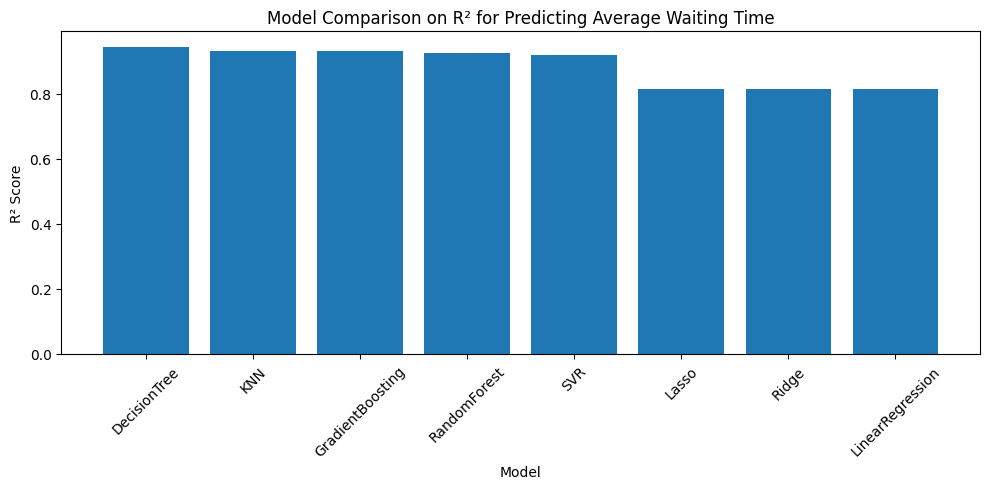

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["R2"])
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Model Comparison on R² for Predicting Average Waiting Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

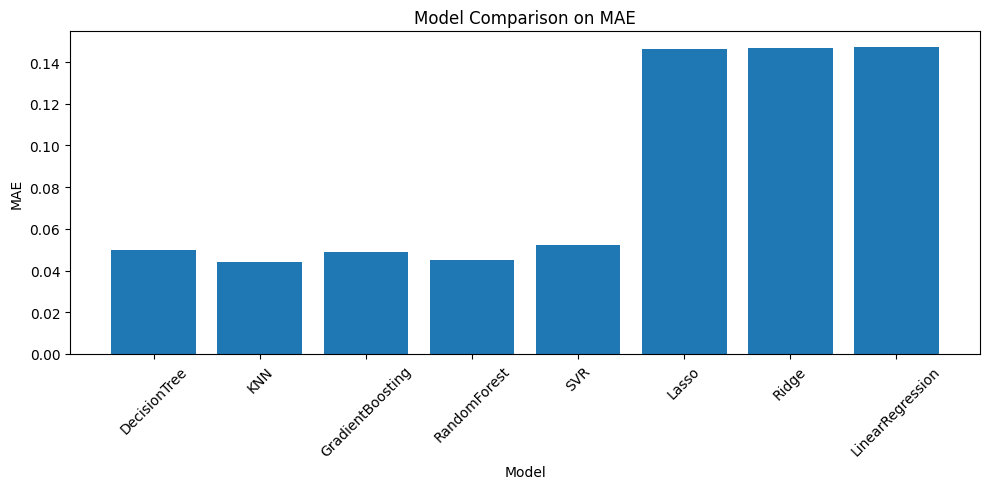

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["MAE"])
plt.xlabel("Model")
plt.ylabel("MAE")
plt.title("Model Comparison on MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
best_row = results_df.iloc[0]
print("Best Model:", best_row["Model"])
print(best_row)

Best Model: DecisionTree
Model    DecisionTree
MAE          0.049864
MSE          0.011842
RMSE         0.108822
R2           0.945095
Name: 3, dtype: object
